## POS tagging using modified Viterbi

### Problem Statement

The vanilla Viterbi algorithm has loss of accuracy majorly due to the fact that when the algorithm encounters an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.
 
In this assignment, you need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques. 

You need to accomplish the following in this assignment:
- Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
- Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
- Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
- List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.


### Data Preparation

In [1]:
#Importing all needed libraries
import nltk, re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
#Total sentences in the tagged dataset
print("Total sentences in the tagged dataset: ",len(nltk_data),"\n")
# first few tagged sentences in the dataset
print(nltk_data[:3])

Total sentences in the tagged dataset:  3914 

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET')

In [4]:
# Splitting the dataset into train and validation sets of of 95:5 
random.seed(1234)
train_set, validation_set = train_test_split(nltk_data,test_size=0.05, random_state=40)

print("Sentences in Training Set :", len(train_set))
print("Sentences in Validation Set :", len(validation_set))

Sentences in Training Set : 3718
Sentences in Validation Set : 196


In [5]:
# Looking at the first 3 sentences in the training set 
print(train_set[:3])

[[('Why', 'ADV'), ('are', 'VERB'), ('programs', 'NOUN'), ('like', 'ADP'), ('this', 'DET'), ('not', 'ADV'), ('eliminated', 'VERB'), ('*-2', 'X'), ('*T*-1', 'X'), ('?', '.')], [('``', '.'), ('Many', 'ADJ'), ('in', 'ADP'), ('the', 'DET'), ('United', 'NOUN'), ('States', 'NOUN'), (',', '.'), ('including', 'VERB'), ('many', 'ADJ'), ('friends', 'NOUN'), ('of', 'ADP'), ('China', 'NOUN'), (',', '.'), ('believe', 'VERB'), ('0', 'X'), ('the', 'DET'), ('crackdown', 'NOUN'), ('was', 'VERB'), ('excessive', 'ADJ'), ('and', 'CONJ'), ('unjustified', 'ADJ'), (',', '.'), ("''", '.'), ('Mr.', 'NOUN'), ('Nixon', 'NOUN'), ('told', 'VERB'), ('Mr.', 'NOUN'), ('Yang', 'NOUN'), (',', '.'), ('who', 'PRON'), ('*T*-242', 'X'), ('was', 'VERB'), ('directly', 'ADV'), ('involved', 'VERB'), ('*-2', 'X'), ('in', 'ADP'), ('*', 'X'), ('ordering', 'VERB'), ('the', 'DET'), ('attack', 'NOUN'), ('*T*-1', 'X'), ('.', '.')], [('Rally', 'NOUN'), ("'s", 'PRT'), ('lost', 'VERB'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('to', 'PRT'), ('21

In [6]:
# Getting list of tagged words in the train set
train_tagged_words = [tup for sent in train_set for tup in sent]
print("Number of tagged words in the Train set:", len(train_tagged_words))

Number of tagged words in the Train set: 96011


In [7]:
# All tokens i.e. the words we have in the train set
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Why',
 'are',
 'programs',
 'like',
 'this',
 'not',
 'eliminated',
 '*-2',
 '*T*-1',
 '?']

In [8]:
# vocabulary of words i.e. number of unique words in the train set
Vocab = set(tokens)
print("Number of unique words in the Train set: ",len(Vocab))

Number of unique words in the Train set:  12117


In [9]:
# number of tags i.e. number of unique POS tags in the train set
Tag = set([pair[1] for pair in train_tagged_words])
print("Number of unique Tags in the Train set: ", len(Tag))
print(Tag)

Number of unique Tags in the Train set:  12
{'ADV', 'VERB', 'PRT', 'X', '.', 'ADP', 'NOUN', 'PRON', 'NUM', 'DET', 'CONJ', 'ADJ'}


Now that we know about the dataset we are dealing with and have done the necessary data preparation, let us build the POS tagger based on the Vanilla Viterbi algorithm. 

### Build the vanilla Viterbi based POS tagger

For Building the Viterbi algorithm , we first need to have the Emission Probabilities and Transition Probabilities.

- **Emission probabilities** which represent the probability that an observation(word) is emitted by a particular state(tag).
- **Transition probabilities** represent the probabilities of transitioning from one state(tags in our case) to another state.

#### Emission Probabilities

In [10]:
# Function to compute word given tag for each word: Emission Probability

def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)                                           # Number of times tag appears in the train set
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)                           # Number of times 'word' has been tagged with 'tag'
    
    return (count_w_given_tag, count_tag)

In [11]:
# Let us see what is the Emission probablity of a word for e.g."is" being assigned a certain tag.
print(word_given_tag('is', 'VERB'))               # probability of word 'is' being a verb
print(word_given_tag('is', 'NOUN'))               # probability of word 'is' being a noun
print(word_given_tag('is', 'DET'))                # probability of word 'is' being a determiner

(644, 12914)
(0, 27533)
(0, 8269)


As we can see, the emission probablity of the word "is" being assigned a tag 'VERB' is greater as compared to "is" being a 'NOUN' or a 'DET'(determiner).(Based on our train dataset)

#### Transition Probabilities

In [12]:
# Function to compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])                   # Number of times tag t1 appears
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1                                      # Number of times tag t1 is followed by tag t2
    return (count_t2_t1, count_t1)

In [13]:
# Let us see what is the transition probability of tags NOUN and VERB
print(t2_given_t1('VERB', 'NOUN'))   #  probablitity of a 'VERB' following a 'NOUN'
print(t2_given_t1('NOUN', 'VERB'))   #  probablitity of a 'NOUN' following a 'VERB'

(4019, 27533)
(1437, 12914)


As we see, the probablitity of a 'VERB' following a 'NOUN' is greater than that of a 'NOUN' following a 'VERB'. (Based on our train dataset).

#### Tags Matrix

In [14]:
# Storing the number of unique Tags
t = len(Tag)
# Storing the number of unique words
v = len(Vocab)

In [15]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((t, t), dtype='float32')
for i, t1 in enumerate(list(Tag)):
    for j, t2 in enumerate(list(Tag)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [16]:
tags_matrix

array([[7.95904920e-02, 3.46763551e-01, 1.35402903e-02, 2.31175702e-02,
        1.37384415e-01, 1.17569350e-01, 3.13738436e-02, 1.45310434e-02,
        3.17040943e-02, 6.77014515e-02, 6.93527097e-03, 1.29788637e-01],
       [8.19265917e-02, 1.68731615e-01, 3.15936208e-02, 2.17748180e-01,
        3.52330804e-02, 9.16834474e-02, 1.11274585e-01, 3.50782089e-02,
        2.29982957e-02, 1.32724181e-01, 5.42047387e-03, 6.55877367e-02],
       [1.04370518e-02, 4.01500314e-01, 1.95694715e-03, 1.33724725e-02,
        4.30528373e-02, 2.02217866e-02, 2.47553810e-01, 1.85909979e-02,
        5.67514673e-02, 9.98043045e-02, 2.28310493e-03, 8.44748840e-02],
       [2.60910820e-02, 2.05249846e-01, 1.84535101e-01, 7.52688199e-02,
        1.62713468e-01, 1.43896267e-01, 6.30929768e-02, 5.48703335e-02,
        2.68817204e-03, 5.37634417e-02, 1.05945608e-02, 1.72359273e-02],
       [5.14653325e-02, 8.89921337e-02, 2.41243746e-03, 2.69835591e-02,
        9.40850601e-02, 9.12258774e-02, 2.22390994e-01, 6.57

In [17]:
# converting the tags matrix to a dataframe for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(Tag), index=list(Tag))
tags_df

,ADV,VERB,PRT,X,.,ADP,NOUN,PRON,NUM,DET,CONJ,ADJ
ADV,0.079590,0.346764,0.013540,0.023118,0.137384,0.117569,0.031374,0.014531,0.031704,0.067701,0.006935,0.129789
VERB,0.081927,0.168732,0.031594,0.217748,0.035233,0.091683,0.111275,0.035078,0.022998,0.132724,0.005420,0.065588
PRT,0.010437,0.401500,0.001957,0.013372,0.043053,0.020222,0.247554,0.018591,0.056751,0.099804,0.002283,0.084475
X,0.026091,0.205250,0.184535,0.075269,0.162713,0.143896,0.063093,0.054870,0.002688,0.053763,0.010595,0.017236
.,0.051465,0.088992,0.002412,0.026984,0.094085,0.091226,0.222391,0.065761,0.081040,0.172713,0.058524,0.044317
ADP,0.013703,0.007967,0.001381,0.035160,0.039728,0.017421,0.321542,0.069683,0.063522,0.322074,0.000956,0.106862
NOUN,0.017179,0.145970,0.043620,0.029129,0.240439,0.176624,0.264918,0.004722,0.009262,0.013402,0.042640,0.012095
PRON,0.034087,0.484106,0.012256,0.092685,0.040597,0.022980,0.208732,0.007660,0.007660,0.009192,0.005362,0.074684
NUM,0.002937,0.018209,0.027019,0.210279,0.116887,0.034949,0.352129,0.001468,0.186197,0.003231,0.013510,0.033186
DET,0.012940,0.039182,0.000242,0.046801,0.017777,0.009312,0.638046,0.003628,0.022373,0.005684,0.000484,0.203531


In [18]:
tags_df.loc['.', :]

ADV     0.051465
VERB    0.088992
PRT     0.002412
X       0.026984
.       0.094085
ADP     0.091226
NOUN    0.222391
PRON    0.065761
NUM     0.081040
DET     0.172713
CONJ    0.058524
ADJ     0.044317
Name: ., dtype: float32

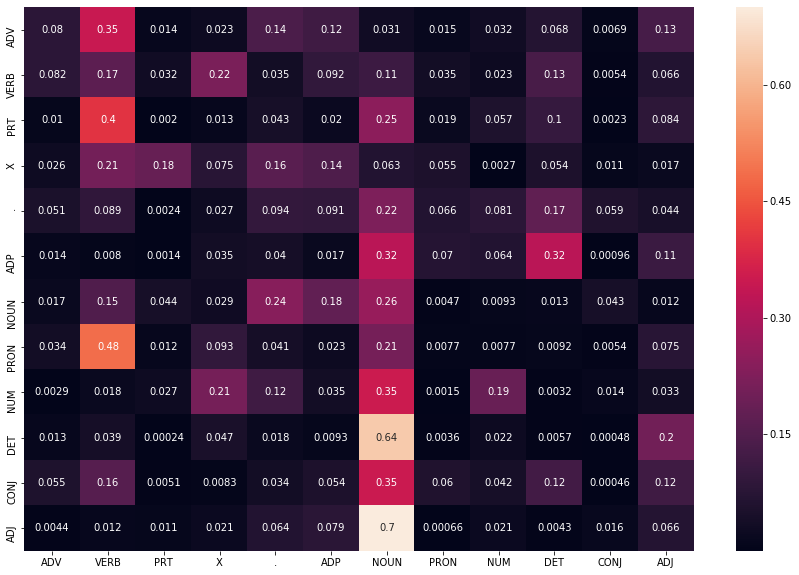

In [19]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(15, 10))
sns.heatmap(tags_df, annot=True)
plt.show()

From the above heatmap, it is clear that-
- the transition probablities of a **'DET'** followed by a **'NOUN'**  and an **'ADJ'** followed by a **'NOUN'** tags are extremely high.
- the probability of a **'DET'** (determiner) followed by a **'PRT'** (particle) is extremely low.


#### The Vanilla Viterbi Algorithm

In [20]:
# Viterbi Heuristic Function

def Viterbi(words, train_bag = train_tagged_words):
    state = []
    Tag_list = list(set([pair[1] for pair in train_bag]))           # Unique list of tags in the train set
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in Tag_list:
            if key == 0:                                            # if the word is the starting word in a sentence
                transition_p = tags_df.loc['.', tag]                
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = Tag_list[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))                                  # Return tagged words

#### Evaluating on Validation Set

In [21]:
# Let's test our Viterbi algorithm on the Validation dataset

random.seed(100)

# list of tagged words in the validation set
validation_run_base = [tup for sent in validation_set for tup in sent]

# list of untagged words extracted from validation set which will be used as input to the Viterbi Algorithm
validation_untagged_words = [tup[0] for sent in validation_set for tup in sent]

In [22]:
# tagging the validation sentences with the Vanilla Viterbi
# Running on the entire validation dataset would take around 30 mins.
start = time.time()
# Calling the Vanilla Viterbi algorithm with untagged word list(of the validation set) as input
Viterbi_tagged_seq = Viterbi(validation_untagged_words)    
end = time.time()
difference = end-start
print("Time taken in Seconds: ", difference)

Time taken in Seconds:  763.1857135295868


In [23]:
# The tags assigned to the validation set by the Vanilla Viterbi
print(Viterbi_tagged_seq)

[('Faulding', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('owns', 'VERB'), ('33', 'NUM'), ('%', 'NOUN'), ('of', 'ADP'), ('Moleculon', 'NOUN'), ("'s", 'PRT'), ('voting', 'NOUN'), ('stock', 'NOUN'), ('and', 'CONJ'), ('has', 'VERB'), ('an', 'DET'), ('agreement', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('acquire', 'VERB'), ('an', 'DET'), ('additional', 'ADJ'), ('19', 'NUM'), ('%', 'NOUN'), ('.', '.'), ('The', 'DET'), ('government', 'NOUN'), ('includes', 'VERB'), ('money', 'NOUN'), ('spent', 'VERB'), ('*', 'X'), ('on', 'ADP'), ('residential', 'ADJ'), ('renovation', 'NOUN'), (';', '.'), ('Dodge', 'NOUN'), ('does', 'VERB'), ("n't", 'ADV'), ('*?*', 'X'), ('.', '.'), ('*', 'X'), ('Beginning', 'ADV'), ('in', 'ADP'), ('1980', 'ADV'), (',', '.'), ('courts', 'NOUN'), ('in', 'ADP'), ('several', 'ADJ'), ('states', 'NOUN'), ('including', 'VERB'), ('California', 'NOUN'), ('and', 'CONJ'), ('New', 'NOUN'), ('York', 'NOUN'), ('decided', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('suspend', 'VERB'), ('

In [24]:
# Function to check accuracy
def check_accuracy(tagged_by_algo, tagged_words):
    check = [i for i, j in zip(tagged_by_algo, tagged_words) if i == j] 
    accuracy = round((100*len(check)/len(tagged_by_algo)),2)
    
    return accuracy 

In [25]:
# Accuracy of the Vanilla Viterbi against the original tags of the validation set
print("Accuracy of the Vanilla Viterbi Algorithm: ", check_accuracy(Viterbi_tagged_seq,validation_run_base ))

Accuracy of the Vanilla Viterbi Algorithm:  91.34


In [26]:
#Cases Incorrectly Tagged by the Vanilla Viterbi 
incorrect_tagged_cases = [[validation_run_base[i-1],j] for i, j in enumerate(zip(Viterbi_tagged_seq, validation_run_base)) if j[0]!=j[1]]
print("Cases incorrectly tagged by the Vanilla Viterbi : ",len(incorrect_tagged_cases))
print(incorrect_tagged_cases)

Cases incorrectly tagged by the Vanilla Viterbi :  404
[[('*', 'X'), (('Beginning', 'ADV'), ('Beginning', 'VERB'))], [('in', 'ADP'), (('1980', 'ADV'), ('1980', 'NUM'))], [('the', 'DET'), (('common-law', 'ADV'), ('common-law', 'NOUN'))], [('common-law', 'NOUN'), (('rule', 'VERB'), ('rule', 'NOUN'))], [('.', '.'), (('Moreover', 'ADV'), ('Moreover', 'ADJ'))], [('the', 'DET'), (('1940s', 'ADV'), ('1940s', 'NUM'))], [('synthetic', 'ADJ'), (('hormone', 'ADV'), ('hormone', 'NOUN'))], [('hormone', 'NOUN'), (('diethylstilbestrol', 'ADV'), ('diethylstilbestrol', 'NOUN'))], [('prevent', 'VERB'), (('miscarriages', 'ADV'), ('miscarriages', 'NOUN'))], [('morning', 'NOUN'), (('sickness', 'ADV'), ('sickness', 'NOUN'))], [('The', 'DET'), (('Internal', 'ADV'), ('Internal', 'NOUN'))], [('who', 'PRON'), (('*T*-123', 'ADV'), ('*T*-123', 'X'))], [('to', 'PRT'), (('report', 'NOUN'), ('report', 'VERB'))], [('report', 'VERB'), (('detailed', 'VERB'), ('detailed', 'ADJ'))], [('who', 'PRON'), (('*T*-124', 'ADV'),

As we see, while the Vanilla Viterbi gave us very good results, but we still have a lot of words that were incorrectly tagged, as those were words it had never encountered in training set and hence, assigned them arbitrary tags.

For e.g.- VERBs like 'sleeping', 'multiplying', 'rescheduled', 'attacking', 'shrinking'; ADJs like 'Palestinian','deceptive','hottest', 'egregious', 'gubernatorial'; NOUNs like 'Bolivia', 'Liberation','centers','duckling' were all incorrectly tagged.

### Solve the problem of unknown words

### 1. Using a Modified Viterbi Algorithm - The Probabilistic approach

Now, let us now modify the algorithm to have better tagging results. 

The first technique we will be using is to modify the Vanilla Viterbi algorithm itself, such that we do not consider the emission probablity of the word not found in the train bag of words for computing its state probability since, emission probbality is zero for such cases.

In [27]:
# Modified Viterbi Function

def Modified_Viterbi(words, train_bag = train_tagged_words):
    state = []
    Tag_list = list(set([pair[1] for pair in train_bag]))            # Unique list of tags in the train set
    Bag = list(set([pair[0] for pair in train_bag]))                 # Unique list of words in the train set
    
    for key, word in enumerate(words):
    #initialise list of probability column for a given observation
        p = []
        if word in Bag:                                             # when word found in Bag        
            for tag in Tag_list:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                 # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p       # calculate state probability normally
                p.append(state_probability)
        else:                                                       # when word is Not found in Bag
            for tag in Tag_list:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                 # compute emission and state probabilities
                state_probability =  transition_p                   # set state probability same as transition probability
                p.append(state_probability)
            
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = Tag_list[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))                                  # Return tagged words

In [28]:
# tagging the validation sentences with the Modified_Viterbi algorithm
# Running on the entire validation dataset would take around 30 mins.
start = time.time()
Mod_Viterbi_tagged_seq = Modified_Viterbi(validation_untagged_words)
end = time.time()
difference = end-start
print("Time taken in Seconds: ", difference)

Time taken in Seconds:  738.997147321701


#### Evaluating tagging accuracy

In [29]:
# Accuracy of the Modified Viterbi against the original tags of the validation set
print("Accuracy of the Modified Viterbi Algorithm: ", check_accuracy(Mod_Viterbi_tagged_seq,validation_run_base))

Accuracy of the Modified Viterbi Algorithm:  94.75


In [30]:
#Cases Incorrectly Tagged by the Modified Viterbi
MV_incorrect_tagged_cases = [[validation_run_base[i-1],j] for i, j in enumerate(zip(Mod_Viterbi_tagged_seq, validation_run_base)) if j[0]!=j[1]]
print("Cases incorrectly tagged by the Modified Viterbi : ", len(MV_incorrect_tagged_cases))

Cases incorrectly tagged by the Modified Viterbi :  245


### 2. Using a Unigram and Rule-Based (Regular Expression) Tagger with the Viterbi

The second technique we will be using to solve the problem of unknown words is the  **Unigram tagger with a Rule-Based - Regular Expression Tagger** on the Viterbi algorithm we already created.

In [31]:
# Unigram + Regex Function to tag the unknown words(words that were not present in the train set)

def regex_uni_tag(v_set_to_tag, V_tagged_seq, train_bag = train_set): # getting untagged word list, Viterbi tagged list
    
    Bag = list(set([pair[0] for pair in train_bag]))              # Bag of Words from Train set
    
    # specify patterns for tagging to be used by the Regex Tagger
    patterns = [
    (r'^(The|the|A|a|An|an)$', 'DET'),                                                   # determiners
    (r'^(This|this|That|that|These|these|Those|those)$', 'DET'),                         # determiners
    (r'(.+ful|.+less|.+ious|.+ial|.+tive|.+able|.+est|.+ic|.+lent)$', 'ADJ'),            # adjectives
    (r'(.+tion|.+tions|.+ment|.+ness|.+or|.+ery|.+ity)$', 'NOUN'),                       # nouns
    (r'^un.+','ADJ'),                                                                    # adjectives
    (r'(.+ing|.+ed)$', 'VERB'),                                                          # verbs
    (r'.+ly$', 'ADV'),                                                                   # adverbs
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),                                                    # numbers
    (r'^[0-9]+.*[0-9]+.?$','NUM'),                                                       # numbers
    (r'(\*|\-)', 'X'),                                                                   # Other 
    (r'(\.|\,|\?|\;|\:)','.'),                                                           # punctuations
    (r'.*', 'NOUN')                                                                      # tag all others as nouns
    ]

    # Creating a RegexTagger
    regexp_tagger = nltk.RegexpTagger(patterns)
    
    # Creating a Unigram_Tagger with RegexTagger as backoff
    uni_regex_tagger = nltk.UnigramTagger(train_bag, backoff = regexp_tagger)
    
    # Tagging the untagged validation words with the Unigram + Regex Tagger
    regexuni_list = uni_regex_tagger.tag(v_set_to_tag)
    
    # Updating Tags as assigned by the Unigram+Regex Tagger, only for the unknown words (not present in train set bag) 
    new_tagged_seq = []
    for V_pair, R_pair in zip(V_tagged_seq,regexuni_list) :  
        if V_pair not in Bag:                                 # if the pair in the Viterbi seq is not in Train Bag
            new_tagged_seq.append(R_pair)                     # assign the tag assigned by the Uni+Regex tagger
        else:
            new_tagged_seq.append(V_pair)                     # else let it have the already tag assigned by Viterbi
    
    return new_tagged_seq

In [32]:
# Calling the Unigram+Regex Tagger with the untagged words list and the Viterbi tagged list as inputs
tagged_by_regexuniVi = regex_uni_tag(validation_untagged_words, Viterbi_tagged_seq)

#### Evaluating tagging accuracy

In [33]:
# Accuracy of the Viterbi with Unigram and Regex tagger
print("Accuracy of the Viterbi Algorithm with Unigram + Regex tagger: ", check_accuracy(tagged_by_regexuniVi,validation_run_base))

Accuracy of the Viterbi Algorithm with Unigram + Regex tagger:  95.84


In [34]:
#Cases Incorrectly Tagged by the Viterbi with Unigram and Regex tagger
regexuni_incorrect_tagged_cases = [[validation_run_base[i-1],j] for i, j in enumerate(zip(tagged_by_regexuniVi, validation_run_base)) if j[0]!=j[1]]
print("Cases incorrectly tagged by the Viterbi with Unigram and Regex tagger : ",len(regexuni_incorrect_tagged_cases))

Cases incorrectly tagged by the Viterbi with Unigram and Regex tagger :  194


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

#### Accuracy Comparison on the Validation Set

In [35]:
print("Accuracy of the Vanilla Viterbi Algorithm: ", check_accuracy(Viterbi_tagged_seq,validation_run_base ))
print("Cases Misidentified : ", len(incorrect_tagged_cases))
print("-"*80)
print("Accuracy of the Modified Viterbi Algorithm: ", check_accuracy(Mod_Viterbi_tagged_seq,validation_run_base))
print("Cases Misidentified : ", len(MV_incorrect_tagged_cases))

print("Accuracy of the Viterbi Algorithm with Unigram + Regex tagger: ", check_accuracy(tagged_by_regexuniVi,validation_run_base))
print("Cases Misidentified : ", len(regexuni_incorrect_tagged_cases))

Accuracy of the Vanilla Viterbi Algorithm:  91.34
Cases Misidentified :  404
--------------------------------------------------------------------------------
Accuracy of the Modified Viterbi Algorithm:  94.75
Cases Misidentified :  245
Accuracy of the Viterbi Algorithm with Unigram + Regex tagger:  95.84
Cases Misidentified :  194


Comparing the tagging accuracies of the modified techniques with the Vanilla Viterbi, we see 
- there is a substantial increase in the tagging accuracy on the validation set with the modified techniques, reducing the incorrectly tagged unknown cases by almost half.
- the accuracy of the Viterbi with Unigram + Regex is the best among these, mostly because of the rules implemented by the Regex tagger when Unigram tagger did not find a suitable tag for the unknown cases. 

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

#### Validation Set Cases

We already saw that words, For e.g.- VERBs like 'sleeping', 'multiplying', 'rescheduled', 'attacking', 'shrinking'; ADJs like 'Palestinian','deceptive', 'hottest','egregious', 'gubernatorial' ; NOUNs like 'Bolivia', 'Liberation', 'centers','duckling' were all incorrectly tagged by the original Viterbi Algorithm. 

Let us see how the Modified Viterbi and the Viterbi with Unigram+Regex performed on these words.

In [36]:
incorrect_list = ['sleeping', 'multiplying', 'rescheduled', 'attacking', 'shrinking',      # Verbs
                  'Palestinian','deceptive','hottest', 'egregious', 'gubernatorial',       # Adjectives
                  'Bolivia', 'Liberation','centers', 'duckling' ]                          # Nouns

In [37]:
for word in Mod_Viterbi_tagged_seq:
    if word[0] in incorrect_list:
        print(word)

('hottest', 'NOUN')
('duckling', 'NOUN')
('multiplying', 'VERB')
('centers', 'VERB')
('attacking', 'VERB')
('deceptive', 'NOUN')
('Palestinian', 'NOUN')
('Palestinian', 'NOUN')
('Liberation', 'NOUN')
('Bolivia', 'X')
('gubernatorial', 'VERB')
('rescheduled', 'X')
('shrinking', 'DET')
('sleeping', 'NOUN')
('egregious', 'NOUN')


So we see the Modified Viterbi was able to correct tags for VERBs 'multiplying', 'attacking' , NOUN 'duckling' , but still others were not corrected.

In [38]:
for word in tagged_by_regexuniVi:
    if word[0] in incorrect_list:
        print(word)

('hottest', 'ADJ')
('duckling', 'VERB')
('multiplying', 'VERB')
('centers', 'VERB')
('attacking', 'VERB')
('deceptive', 'ADJ')
('Palestinian', 'NOUN')
('Palestinian', 'NOUN')
('Liberation', 'NOUN')
('Bolivia', 'NOUN')
('gubernatorial', 'ADJ')
('rescheduled', 'VERB')
('shrinking', 'VERB')
('sleeping', 'VERB')
('egregious', 'ADJ')


We see the Viterbi with Unigram+Regex was able to correct tags for most of these words we have chosen. Note, how NOUN 'duckling' was assigned incorrect tag because of a verb rule. But still the performance of this tagger is noteworthy. So, Let us see the performance of these techniques on test data.

### Performance on the Test set

In [39]:
# Preparation on the test set
test_set = pd.read_csv("Test_sentences.txt", sep="\n", names=["Sentence"])
test_set = test_set.values.tolist()
test_set

[['Android is a mobile operating system developed by Google.'],
 ['Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'],
 ["Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."],
 ['Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'],
 ['Before entering politics, Donald Trump was a domineering businessman and a television personality.'],
 ['The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'],
 ['This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.'],
 ['Show me the cheapest round trips from Dallas to Atlanta'],
 ['I would like to see flights from Denver to Philadelphia.'],
 ['Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.'],
 ['NASA invited social med

In [40]:
random.seed(1234)
# list of words in the test_set
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words in the test set
test_words = [word for sent in test_run_base for word in sent.split()]
test_words[:10]

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google.',
 'Android']

We see that in all these test sentences, the punctuations are clubbed together with the preceding words, for eg. 'Google.', 'politics,' 'Cup,' etc.
Let us split these up to have a cleaner test set.

In [41]:
# Splitting the punctuations ',.;' etc. from the preceding words
test_untagged_words = []
for word in test_words:
    if word[-1] in [".",",",";",":"]:
        print("Splitting", word[:-1], word[-1])
        test_untagged_words.append(word[:-1])
        test_untagged_words.append(word[-1])
    else:
        test_untagged_words.append(word)        

Splitting Google .
Splitting 2013 .
Splitting firehose .
Splitting tweets .
Splitting politics ,
Splitting personality .
Splitting Cup ,
Splitting years .
Splitting Europe .
Splitting Philadelphia .
Splitting Francisco .
Splitting Satellite .


#### Performance of the Vanilla Viterbi on the Test Set

In [42]:
# tagging the test sentences with the Vanilla Viterbi with untagged test words as input
start = time.time()
Viterbi_tagged = Viterbi(test_untagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(Viterbi_tagged)

Time taken in seconds:  30.878447771072388
[('Android', 'ADV'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADV'), ('.', '.'), ('Android', 'ADV'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADV'), ('worldwide', 'ADV'), ('on', 'ADP'), ('smartphones', 'ADV'), ('since', 'ADP'), ('2011', 'ADV'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADV'), ('.', '.'), ('Google', 'ADV'), ('and', 'CONJ'), ('Twitter', 'ADV'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADV'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADV'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'ADV'), ('firehose', 'ADV'), ('.', '.'), ('Twitter', 'ADV'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADV'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('

We see when we tag the Test set using the Vanilla Viterbi, we have a lot of misidentified unknown words. 
For e.g.
- 'Android'
- 'Google'
- 'Twitter'
- 'smartphones'
- 'contested'
- 'tweets'
- 'NASA'
- 'trips'
- 'Satellite'
- '2011', '2013'
- 'arriving'
- 'invited'

#### Performance of the Modified Viterbi on the Test Set

In [43]:
# tagging the test sentences with the Modified Viterbi with untagged test words as input
start = time.time()
MV_tagged = Modified_Viterbi(test_untagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(MV_tagged)

Time taken in seconds:  23.658952474594116
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'VERB'), ('firehose', 'X'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'

We can see that the Modified Viterbi was able to correct few tags such as
- ('Android', 'NOUN')
- ('Twitter', 'NOUN')
- ('NASA', 'NOUN')
- ('Satellite', 'NOUN')
- ('trips', 'NOUN')

But there are still misidentified unknown words such as below-
- 'Google'
- 'smartphones'
- 'contested'
- 'tweets'
- '2011', '2013'
- 'arriving'
- 'invited'

#### Performance of the Viterbi with Unigram + Regex Tagger on the Test Set

In [44]:
# tagging the test sentences with the Viterbi with Unigram and Regex 
# with untagged test words and the Viterbi tagged test set as input
start = time.time()
RegexuniVi_tagged = regex_uni_tag(test_untagged_words, Viterbi_tagged)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(RegexuniVi_tagged)

Time taken in seconds:  1.7171790599822998
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'NOUN'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on

Using the Viterbi with Unigram and Regex, we have more correctly classified cases as below-
- ('Android', 'NOUN')
- ('Google', 'NOUN')
- ('Twitter', 'NOUN')
- ('smartphones', 'NOUN')
- ('contested', 'VERB')
- ('tweets', 'NOUN')
- ('NASA', 'NOUN')
- ('trips', 'NOUN')
- ('Satellite', 'NOUN')
- ('2011', 'NUM')
- ('2013', 'NUM')
- ('arriving', 'VERB')
- ('invited', 'VERB')

#### Comparing Accuracies of the techniques on the Test set

In [45]:
# Tagging test set with nltk POS Tagger of Universal tagset against which we will compare the accuracies
test_tagged_words = nltk.pos_tag(test_untagged_words, tagset='universal')

In [46]:
print("Accuracy Comparison on the Test Set :")
print("-"*80)
# Accuracy of the Vanilla Viterbi on Test set
print("Accuracy of the Vanilla Viterbi Algorithm: ", check_accuracy(Viterbi_tagged, test_tagged_words))

# Accuracy of the Modified Viterbi on the Test Set
print("Accuracy of the Modified Viterbi Algorithm: ", check_accuracy(MV_tagged, test_tagged_words))

# Accuracy of the Viterbi with Unigram+Regex on the Test Set
print("Accuracy of the Viterbi Algorithm with Unigram+Regex : ", check_accuracy(RegexuniVi_tagged, test_tagged_words))

Accuracy Comparison on the Test Set :
--------------------------------------------------------------------------------
Accuracy of the Vanilla Viterbi Algorithm:  76.11
Accuracy of the Modified Viterbi Algorithm:  86.67
Accuracy of the Viterbi Algorithm with Unigram+Regex :  93.89
